In [108]:
import sys
sys.path.append('/home/jovyan')
import read_data
from io import StringIO

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import seaborn as sns

In [109]:
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_memory_total_rss"}
start_time = '2024-04-22T09:15:13.908Z'
end_time = '2024-04-22T10:05:20.908Z'
out = read_data.read_data(dict_data, start_time, end_time)

In [110]:
print(len(out))

19117697


In [111]:
lines = out.split('\n')
for i in range (10):
    print(lines[i])

"time","name","value","unit","metric.attributes.case_number","metric.attributes.pipeline_id","metric.attributes.slurm_job_id","metric.attributes.step_name","metric.attributes.pipeline_name"
"2024-04-22T09:41:04.807003887Z","slurm_job_memory_total_rss","29978624.0","","Paper_cohort_0064_Pinaki_na","5","8691396","bonestrength_markov","Real1_5"
"2024-04-22T09:41:07.944952148Z","slurm_job_memory_total_rss","51515392.0","","Paper_cohort_0064_Pinaki_na","5","8691396","bonestrength_markov","Real1_5"
"2024-04-22T09:41:11.144557778Z","slurm_job_memory_total_rss","825290752.0","","Paper_cohort_0064_Pinaki_na","5","8691396","bonestrength_markov","Real1_5"
"2024-04-22T09:41:14.247516134Z","slurm_job_memory_total_rss","1102864384.0","","Paper_cohort_0064_Pinaki_na","5","8691396","bonestrength_markov","Real1_5"
"2024-04-22T09:41:17.365762485Z","slurm_job_memory_total_rss","1484042240.0","","Paper_cohort_0064_Pinaki_na","5","8691396","bonestrength_markov","Real1_5"
"2024-04-22T09:41:20.494649214Z","s

In [68]:
def plot_agregation(df, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(16, 8));  a = sns.lineplot(ax=ax, data=df, x="time", y="value")
    
    min_time = df['time'].min()
    max_time = df['time'].max()
    selected_times = pd.date_range(start=min_time, end=max_time, periods=30)
    ax.set_xticks(selected_times)
    
    date_form = DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(date_form)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    rotation = plt.xticks(rotation=45)

In [69]:
def plot_histogram(df, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(16, 8));  a = sns.histplot(grouped_df['value'], bins=10, color='skyblue', edgecolor='black')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    

In [98]:
def plot_grid_set(df, ylabel):

    g = sns.FacetGrid(df, col='metric.attributes.slurm_job_id', col_wrap=3, height=4, sharex=False, sharey=False)
    g.map_dataframe(sns.lineplot, x='time', y='value')
    
    date_format = DateFormatter("%H:%M:%S")
    for ax in g.axes.flat:
        ax.xaxis.set_major_formatter(date_format)
    for ax in g.axes.flat:
        ax.set_xticks(ax.get_xticks()[::len(ax.get_xticks())//2])
    
    for ax in g.axes.flat:
        job_id = ax.get_title().split(" = ")[-1].strip()
        # print(job_id)
        subset = df[df['metric.attributes.slurm_job_id'] == int(job_id)]
        # print("subset: ")
        # print(subset)
        # print()
        max_value = subset['value'].max()
        ax.set_ylim(0, max_value * 1.1)

    ax.set_ylabel(ylabel)
    plt.tight_layout()


def plot_grid(df, ylabel):
    unique_job_ids = df['metric.attributes.slurm_job_id'].unique()
    # print(len(unique_job_ids))
    max_length = 99
    job_id_sets = [unique_job_ids[i:i+max_length] for i in range(0, len(unique_job_ids), max_length)]

    for job_id_set in job_id_sets:
        current_df = df[df['metric.attributes.slurm_job_id'].isin(job_ids)]
        plot_grid_set(current_df, ylabel)
    

In [72]:
start_time = '2024-04-22T09:15:13.908Z'
end_time = '2024-04-22T10:05:20.908Z'

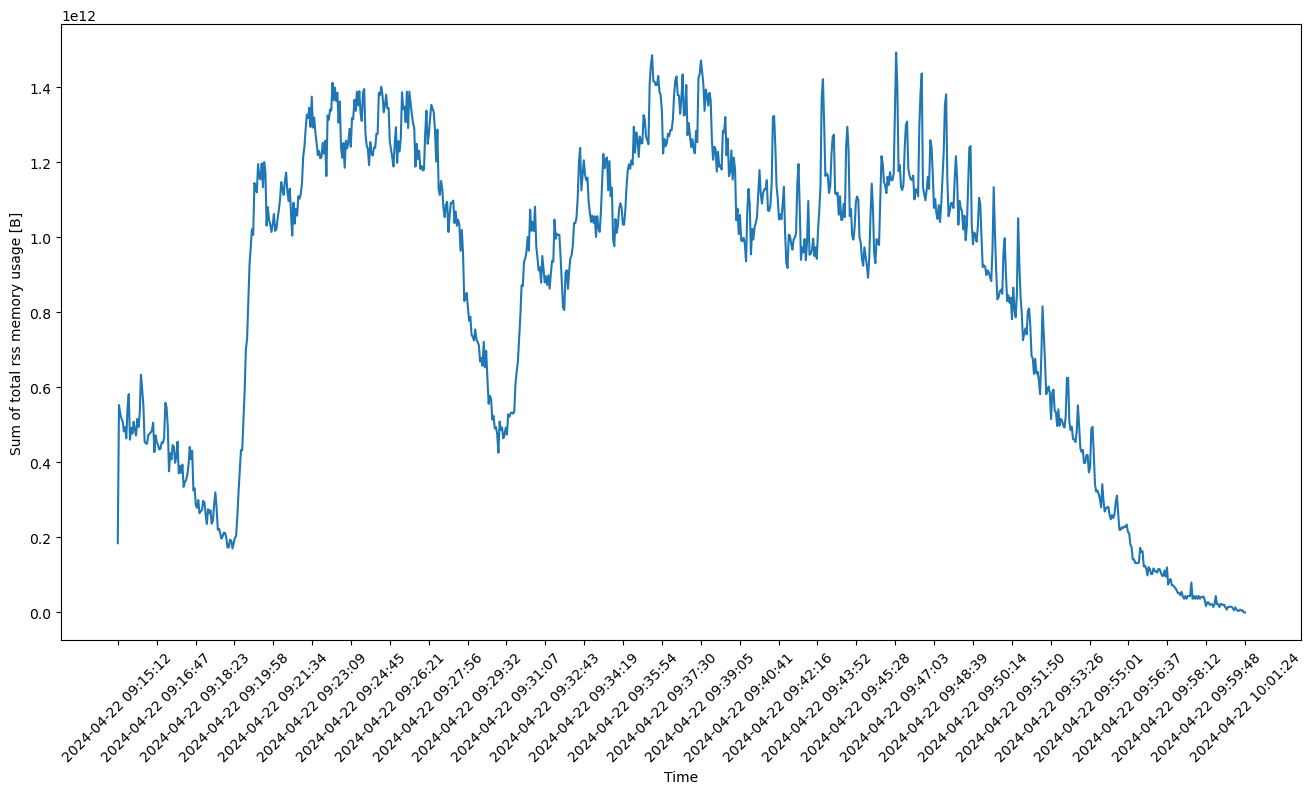

In [73]:
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_memory_total_rss"}
csv_data = read_data.read_data(dict_data, start_time, end_time)

df = pd.read_csv(StringIO(csv_data))
df['time'] = pd.to_datetime(df['time'])

df['time'] = df['time'].dt.floor('3s')
df = df.groupby(['time']).sum().reset_index()

plot_agregation(df, 'Time', 'Sum of total rss memory usage [B]')

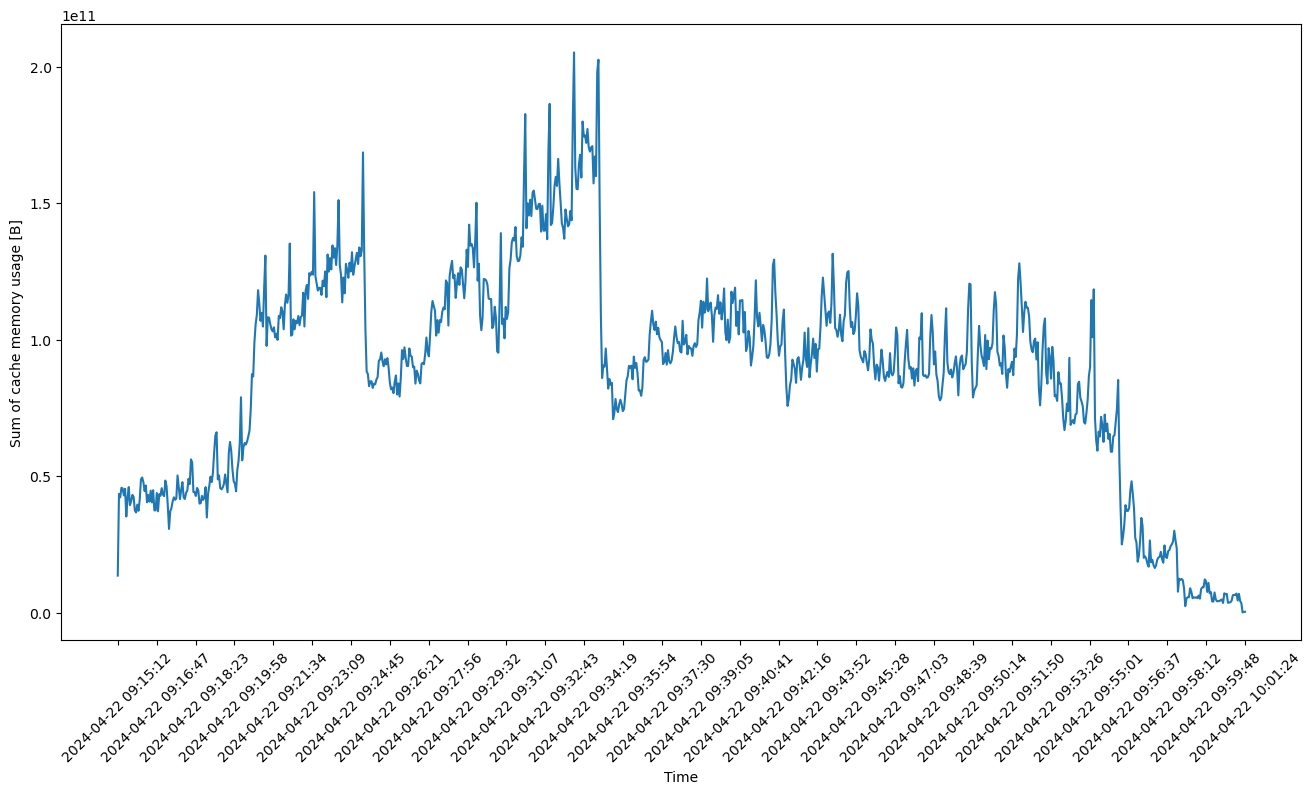

In [74]:
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_memory_total_cache"}
csv_data = read_data.read_data(dict_data, start_time, end_time)

df = pd.read_csv(StringIO(csv_data))
df['time'] = pd.to_datetime(df['time'])

df['time'] = df['time'].dt.floor('3s')
df = df.groupby(['time']).sum().reset_index()

plot_agregation(df, 'Time', 'Sum of cache memory usage [B]')

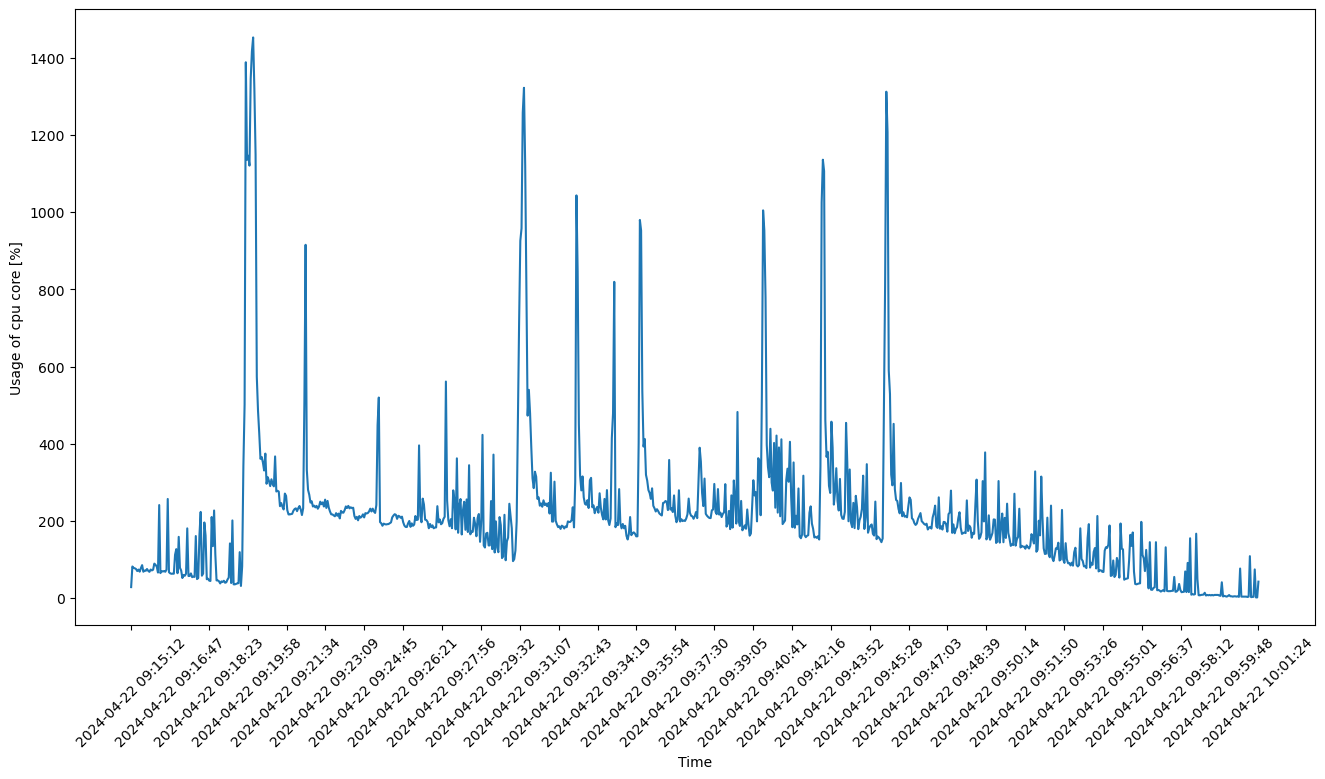

In [75]:
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_cpu_percent"}
csv_data = read_data.read_data(dict_data, start_time, end_time)

df = pd.read_csv(StringIO(csv_data))
df['time'] = pd.to_datetime(df['time'])

df['time'] = df['time'].dt.floor('3s')
df = df.groupby(['time']).sum().reset_index()

plot_agregation(df, 'Time', 'Usage of cpu core [%]')

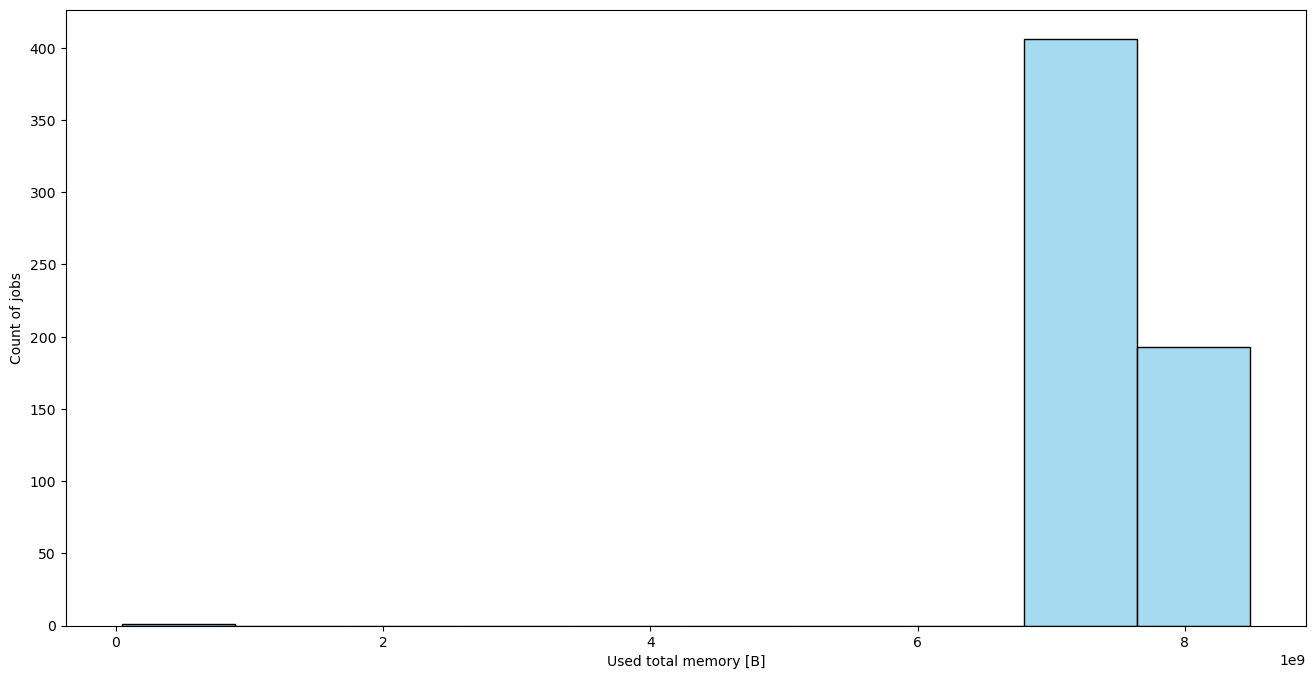

In [101]:
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_memory_total_rss"}
csv_data = read_data.read_data(dict_data, start_time, end_time)

df = pd.read_csv(StringIO(csv_data))
df['time'] = pd.to_datetime(df['time'])

grouped_df = df.groupby('metric.attributes.slurm_job_id')['value'].max().reset_index()


plot_histogram(grouped_df, 'Used total memory [B]', 'Count of jobs')

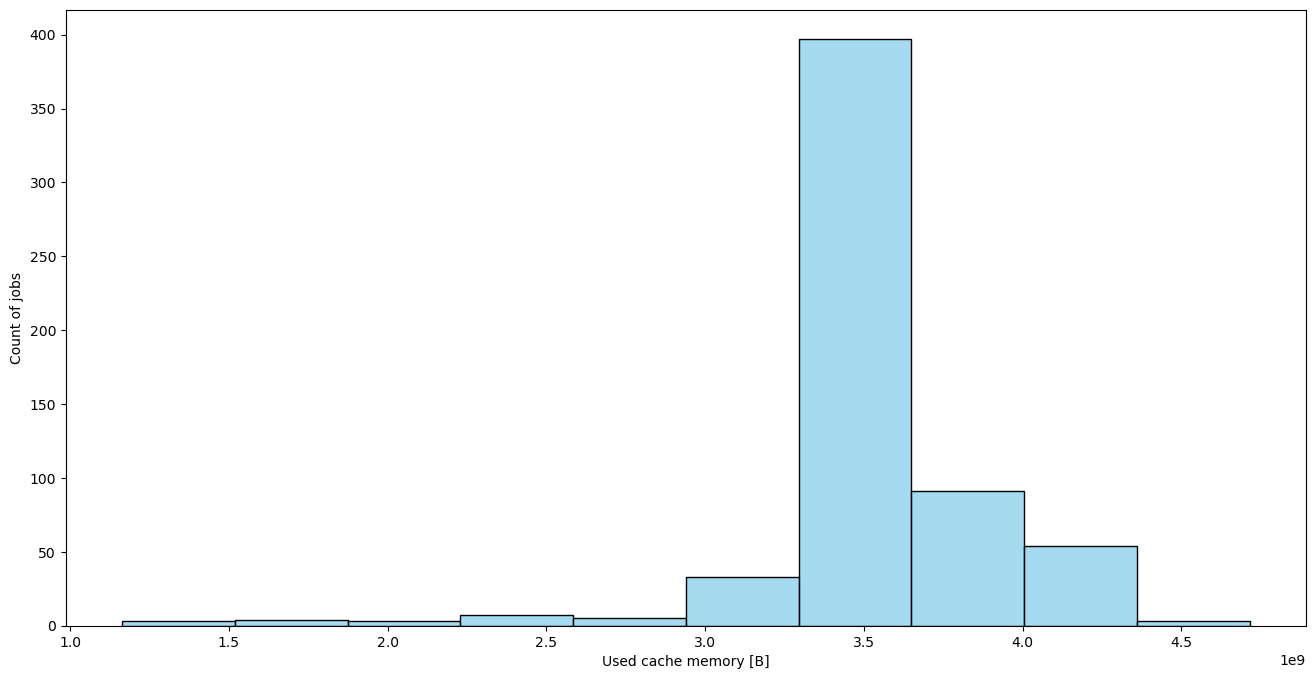

In [102]:
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_memory_total_cache"}
csv_data = read_data.read_data(dict_data, start_time, end_time)

df = pd.read_csv(StringIO(csv_data))
df['time'] = pd.to_datetime(df['time'])

grouped_df = df.groupby('metric.attributes.slurm_job_id')['value'].max().reset_index()


plot_histogram(grouped_df, 'Used cache memory [B]', 'Count of jobs')

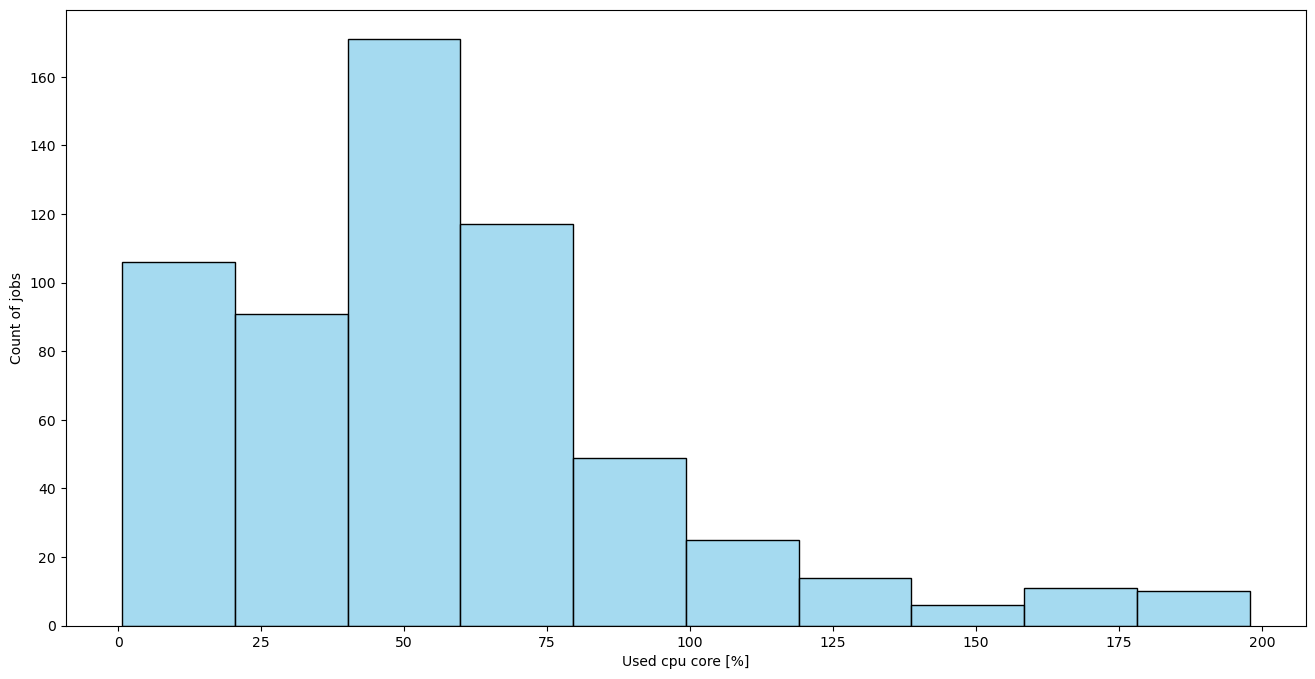

In [103]:
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_cpu_percent"}
csv_data = read_data.read_data(dict_data, start_time, end_time)

df = pd.read_csv(StringIO(csv_data))
df['time'] = pd.to_datetime(df['time'])

grouped_df = df.groupby('metric.attributes.slurm_job_id')['value'].max().reset_index()


plot_histogram(grouped_df, 'Used cpu core [%]', 'Count of jobs')

In [106]:
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_memory_total_rss"}
csv_data = read_data.read_data(dict_data, start_time, end_time)

df = pd.read_csv(StringIO(csv_data))
df['time'] = pd.to_datetime(df['time'])

# plot_grid(df, 'Used total memory [B]')

In [107]:
dict_data = {"metric.attributes.user": "plgkarolzajac", "name": "slurm_job_cpu_percent"}
csv_data = read_data.read_data(dict_data, start_time, end_time)

df = pd.read_csv(StringIO(csv_data))
df['time'] = pd.to_datetime(df['time'])

# plot_grid(df, 'Usege of cpu core [%]')